This notebook loads data stored in text files, formats and stored into pandas dataframes. Some additional producs are computed and stored in dataframes, including uncertainty band and chl anomaly. The dataframes are then pickled for plotting in a later notebook.

In [1]:
import pandas as pd
import pathlib
from datetime import datetime
import pickle
from scipy.stats import mode
import numpy as np
from IPython.core.display import HTML, display
import matplotlib.pyplot as pl
from matplotlib import rcParams
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import pymc3 as pm

In [2]:
%matplotlib inline

In [3]:
def convert_secs2dt(sec):
    """
    Converts seconds to python datetime object.
    :param sec 
    :return: datetime object
    """
    zd00 = datetime(2000, 1, 1)
    zd70 = datetime(1970, 1, 1)
    offset = (zd00 - zd70).total_seconds()
    z = datetime.utcfromtimestamp(sec + offset)
    return z


def get_doy(secs):
    """
    Converts seconds to fractional day of year.
    :param secs
    :return: fractional day of year 
    """
    z = convert_secs2dt(secs)
    y = z.year
    return (secs + (datetime(2000, 1, 1) - datetime(y, 1, 1)).total_seconds()) / 86400


def load_format_data(filepath, minimal=True, columns=None, quantity='chl_a'):
    """
    Loads chlorophyll data into a pandas dataframe,
    formats time entries, and creates a datetime index.
    :param filepath: string or pathlib object  
    :param minimal: if True returns only chl_a_mean; drops the rest.
    :return: pandas datetime indexed dataframe
    """
    if columns is None:
        columns = ['time', 'nbins', 'mean', 'median', 'stdv']
    
    df = pd.read_csv(filepath, delim_whitespace=True, names=columns)
    df['datetime'] = df.time.apply(convert_secs2dt)
    df.set_index('datetime', inplace=True)
    if minimal:
        df = df[['mean']]
    df.rename(columns={'mean': '%s_mean' % quantity}, inplace=True)
    return df


def regress_phyto_c(df, mean_col_label='bbp_443_giop_mean',
                   reg_slope=12128, reg_bias=0.59):
    df['phyto_c'] = df[mean_col_label] * reg_slope + reg_bias
    return df


def get_monthly_means(df, **kwargs):
    """
    Groups data by month and compute annual cycle based on monthly means.
    :param df: 
        datetime indexed pandas dataframe
    :param kwargs:
        year_start (optional): string, slice start
        year_end (optional): string, slice end
    :return: 
        month-indexed pandas dataframe with monthly means
    """
    year_start = kwargs.pop('year_start', df.index.year[0])
    year_end = kwargs.pop('year_end', df.index.year[-1])
    return df.loc[str(year_start): str(year_end)].groupby(lambda x: x.month).aggregate('mean')


def get_anomaly(df, df_ann_cycle, name='chl_a_mean', anomaly_name='anomaly'):
    """
    Computes annomaly by removing monthly mean for a given month
    :param df:
        pandas dataframe with [name] parameter column
    :param df_ann_cycle:
        pandas dataframe of length 12 containing monthly means
    :param name:
        str, label of quantity to get anomaly from
    :return:
        None
    """

    for month in df_ann_cycle.index:
        idx = df.index.month == month
        df.loc[idx, anomaly_name] = df.loc[idx, name] - df_ann_cycle.loc[month, name]


def test(datadir):
    testfile = datadir / 'ar2018.0m_AtlN55_chlor_a.txt'
    df_test = load_format_data(testfile, minimal=False)
    t0 = df_test.time[0]    
    z0 = convert_secs2dt(t0)
    zstr0 = z0.strftime('%Y%j%H%M%S')
    try:
        assert zstr0 + '000' == str(2002197194740000)
    except AssertionError as e:
        print(e)
        print(zstr0)
    assert z0.year == 2002
    doy0 = get_doy(t0)
    assert doy0 == 196.82476851851851
    tl = df_test.tail(1).time.values
    zl = convert_secs2dt(tl)
    zstrl = zl.strftime('%Y%j%H%M%S')
    assert zstrl + '000' == str(2016321013320000)
    assert zl.year == 2016
    doyl = get_doy(tl)
    assert doyl == 320.06481481481484
    print("all tests passed")

In [4]:
# Global graphics setup
display(HTML("<style>.container {width: 90%}</style>"))
plot_colors = {'consolidated': '#000000',
               'aqua': '#348ABD',
               'swf': '#A60628',
               'mei': '#467821',
               }
rcParams['axes.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
rcParams['font.size'] = 15
rcParams['ytick.major.size'] = 8
rcParams['ytick.minor.size'] = 3
rcParams['xtick.major.size'] = 8
rcParams['xtick.minor.size'] = 3
rcParams['xtick.top'] = True
rcParams['ytick.direction'] = 'in'
rcParams['xtick.direction'] = 'in'
rcParams['axes.formatter.limits'] = (-2, 3)

In [7]:
# Paths
home = pathlib.Path.home()
dataMain = home / 'DEV-ALL/State_of_the_Climate/soc2018/TIMESERIES/'
test_dir = dataMain / 'pso_test/'

aquadir = dataMain / 'ar2018.0m_ar2018.0m/stats'
aquaIOPdir = dataMain / 'ar2018.0IOPm_ar2018.0IOPm/stats'

swfdir = dataMain / 'sr2018.0m_sr2018.0m/stats'
swfIOPdir = dataMain / 'sr2018.0IOPm_sr2018.0IOPm/stats'

fp_chlor_a_aqua = aquadir / 'ar2018.0m_eqsst_chlor_a.txt'
fp_chlor_a_swf = swfdir / 'sr2018.0m_eqsst_chlor_a.txt'

fp_bbp_443_giop_aqua = test_dir/'at168m_eqsst_bbp_443_giop.txt'
fp_bbp_443_giop_swf = test_dir /'st134m_eqsst_bbp_443_giop.txt'
#test(test_aquadir)

In [8]:
# Load the data into pandas dataframes, with some datetime formatting
df_swf = load_format_data(fp_chlor_a_swf,)
df_aqua = load_format_data(fp_chlor_a_aqua)

df_swf_bbp = load_format_data(fp_bbp_443_giop_swf, quantity='bbp_443_giop')
df_aqua_bbp = load_format_data(fp_bbp_443_giop_aqua, quantity='bbp_443_giop')

In [9]:
df_aqua.tail()

,chl_a_mean
datetime,
2018-08-16 13:43:20,0.143987
2018-09-16 01:30:00,0.144530
2018-10-16 13:33:20,0.134381
2018-11-16 01:30:00,0.126977
2018-12-16 13:23:20,0.135522


In [10]:
df_aqua_bbp.tail()

,bbp_443_giop_mean
datetime,
2018-08-16 13:43:20,0.001921
2018-09-16 01:30:00,0.001958
2018-10-16 13:33:20,0.002058
2018-11-16 01:30:00,0.002047
2018-12-16 13:23:20,0.001954


In [11]:
df_aqua_bbp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 198 entries, 2002-07-16 22:17:30 to 2018-12-16 13:23:20
Data columns (total 1 columns):
bbp_443_giop_mean    198 non-null float64
dtypes: float64(1)
memory usage: 3.1 KB


In [12]:
df_aqua.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 198 entries, 2002-07-16 22:10:00 to 2018-12-16 13:23:20
Data columns (total 1 columns):
chl_a_mean    198 non-null float64
dtypes: float64(1)
memory usage: 3.1 KB


In [13]:
df_aqua.head()

,chl_a_mean
datetime,
2002-07-16 22:10:00,0.134046
2002-08-19 09:03:30,0.144239
2002-09-16 01:52:30,0.162506
2002-10-16 13:17:30,0.144815
2002-11-16 01:15:00,0.138069


In [14]:
with open('./pklJar/pooled_params.pkl', 'rb') as fb:
    pooled_params_dict = pickle.load(fb)
slope = pooled_params_dict['slope']
slope = slope.reshape(-1, 1)
intercept = pooled_params_dict['intercept']
intercept = intercept.reshape(-1, 1)

In [14]:
slope

array([[11326.71323861],
       [11575.60502179],
       [13388.84532016],
       ...,
       [11477.07027525],
       [11940.15722534],
       [10296.00932882]])

In [15]:
def set_time_axis(ax):
    x_minorlocator = mdates.YearLocator()
    x_majorformatter = mdates.DateFormatter('%b\n%Y')
    ax.xaxis.set_minor_locator(x_minorlocator)
    ax.xaxis.set_tick_params(rotation=0)
    ax.xaxis.set_major_formatter(x_majorformatter)
    ax.set_xlabel('')
    
def compute_phyto_C_stats(df_):
    bbp_443_ = df_.bbp_443_giop_mean.values.reshape(1,-1)
    phyto_c_trace_ = intercept + bbp_443_ * slope
    phyto_c_mean = phyto_c_trace_.mean(axis=0)
    phyto_c_hpd = pm.hpd(phyto_c_trace_)
    df_.insert(loc=1, column='phyto_C_2.5%', value=phyto_c_hpd[:, 0])
    df_.insert(loc=2, column='phyto_C_97.5%', value=phyto_c_hpd[:, 1])
    df_.insert(loc=2, column='phyto_C_mean', value=phyto_c_mean)

In [16]:
df_a = pd.concat((df_aqua, df_aqua_bbp), axis=1)

In [17]:
df_s = pd.concat((df_swf, df_swf_bbp), axis=1)

In [18]:
df_s.columns = ['s_%s' % col for col in df_s.columns]

In [19]:
swf_good_per_ends = '2007-12-31'

In [20]:
df_s = df_s.loc[:swf_good_per_ends]

In [21]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122 entries, 1997-11-15 22:47:10 to 2007-12-16 10:50:00
Data columns (total 2 columns):
s_chl_a_mean           122 non-null float64
s_bbp_443_giop_mean    122 non-null float64
dtypes: float64(2)
memory usage: 2.9 KB


In [22]:
df_a.columns = ['a_%s' % col for col in df_a.columns]

In [23]:
df_all = pd.concat(
                    (df_s.resample('MS', loffset=pd.Timedelta(14, 'd')).first(),
                    df_a.resample('MS', loffset=pd.Timedelta(14, 'd')).first()),
    axis=1)

In [24]:
df_all.head()

,s_chl_a_mean,s_bbp_443_giop_mean,a_chl_a_mean,a_bbp_443_giop_mean
datetime,,,,
1997-11-15,0.128396,0.002114,NaN,NaN
1997-12-15,0.128360,0.002029,NaN,NaN
1998-01-15,0.128007,0.001987,NaN,NaN
1998-02-15,0.126971,0.001973,NaN,NaN
1998-03-15,0.128490,0.002002,NaN,NaN


In [25]:
df_all.tail()

,s_chl_a_mean,s_bbp_443_giop_mean,a_chl_a_mean,a_bbp_443_giop_mean
datetime,,,,
2018-08-15,NaN,NaN,0.143987,0.001921
2018-09-15,NaN,NaN,0.144530,0.001958
2018-10-15,NaN,NaN,0.134381,0.002058
2018-11-15,NaN,NaN,0.126977,0.002047
2018-12-15,NaN,NaN,0.135522,0.001954


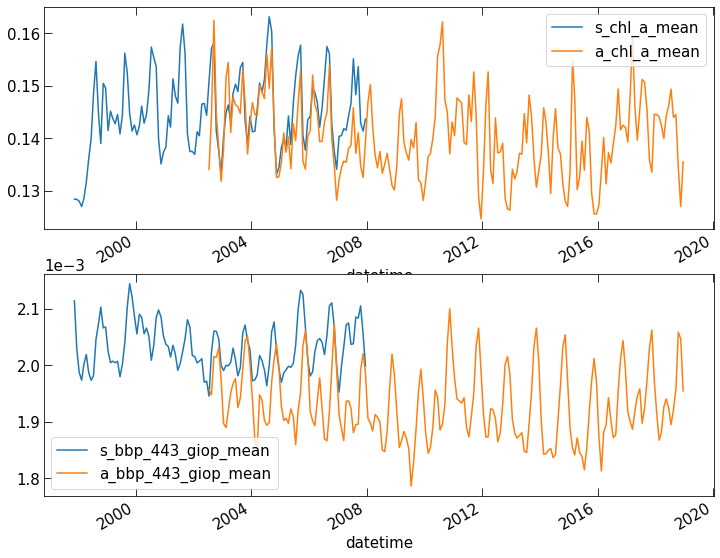

In [26]:
_, ax = pl.subplots(nrows=2, figsize=(12, 10))
df_all.plot(y=['s_chl_a_mean', 'a_chl_a_mean'], ax=ax[0])
df_all.plot(y=['s_bbp_443_giop_mean', 'a_bbp_443_giop_mean'], ax=ax[1])

In [27]:
df_both=df_all.dropna().copy()

In [28]:
df_all.head()

,s_chl_a_mean,s_bbp_443_giop_mean,a_chl_a_mean,a_bbp_443_giop_mean
datetime,,,,
1997-11-15,0.128396,0.002114,NaN,NaN
1997-12-15,0.128360,0.002029,NaN,NaN
1998-01-15,0.128007,0.001987,NaN,NaN
1998-02-15,0.126971,0.001973,NaN,NaN
1998-03-15,0.128490,0.002002,NaN,NaN


In [29]:
df_both.head()

,s_chl_a_mean,s_bbp_443_giop_mean,a_chl_a_mean,a_bbp_443_giop_mean
datetime,,,,
2002-07-15,0.150883,0.001945,0.134046,0.001956
2002-08-15,0.157160,0.002023,0.144239,0.001947
2002-09-15,0.158189,0.002060,0.162506,0.002015
2002-10-15,0.141323,0.002060,0.144815,0.002014
2002-11-15,0.137566,0.002046,0.138069,0.002030


In [30]:
df_both.insert(0, 'chl_mean',
               df_both[['s_chl_a_mean',
                        'a_chl_a_mean']].mean(axis=1))
df_both.insert(1, 'bbp443_mean',
               df_both[['s_bbp_443_giop_mean',
                        'a_bbp_443_giop_mean']].mean(axis=1))

In [31]:
df_both.insert(1, 'aqua-chl_mean', df_both.a_chl_a_mean - df_both.chl_mean)
df_both.insert(1, 'chl_mean-swf', df_both.chl_mean - df_both.s_chl_a_mean)

In [32]:
df_both.insert(4, 'aqua-bbp443_mean', df_both.a_bbp_443_giop_mean - df_both.bbp443_mean)
df_both.insert(4, 'bbp443_mean-swf', df_both.bbp443_mean - df_both.s_bbp_443_giop_mean)

In [33]:
df_both.head().T

datetime,2002-07-15 00:00:00,2002-08-15 00:00:00,2002-09-15 00:00:00,2002-10-15 00:00:00,2002-11-15 00:00:00
chl_mean,0.142464,0.150699,0.160347,0.143069,0.137818
chl_mean-swf,-0.008418,-0.006461,0.002158,0.001746,0.000251
aqua-chl_mean,-0.008418,-0.006460,0.002159,0.001746,0.000251
bbp443_mean,0.001951,0.001985,0.002038,0.002037,0.002038
bbp443_mean-swf,0.000006,-0.000038,-0.000023,-0.000023,-0.000008
aqua-bbp443_mean,0.000006,-0.000038,-0.000023,-0.000023,-0.000008
s_chl_a_mean,0.150883,0.157160,0.158189,0.141323,0.137566
s_bbp_443_giop_mean,0.001945,0.002023,0.002060,0.002060,0.002046
a_chl_a_mean,0.134046,0.144239,0.162506,0.144815,0.138069
a_bbp_443_giop_mean,0.001956,0.001947,0.002015,0.002014,0.002030


In [34]:
df_all['adj_chl_s'] = df_all.s_chl_a_mean + df_both['chl_mean-swf'].mean()

In [35]:
df_all['adj_chl_a'] = df_all.a_chl_a_mean - df_both['aqua-chl_mean'].mean()
df_all['adj_bbp_s'] = df_all.s_bbp_443_giop_mean + df_both['bbp443_mean-swf'].mean()

In [36]:
df_all['adj_bbp_a'] = df_all.a_bbp_443_giop_mean - df_both['aqua-bbp443_mean'].mean()

In [37]:
df_all['chl_adj_mean'] = df_all[['adj_chl_s', 'adj_chl_a']].mean(axis=1)
df_all['bbp_adj_mean'] = df_all[['adj_bbp_s', 'adj_bbp_a']].mean(axis=1)

In [38]:
df_all['adj_chl_a'].tail()

datetime
2018-08-15    0.145831
2018-09-15    0.146374
2018-10-15    0.136225
2018-11-15    0.128821
2018-12-15    0.137366
Name: adj_chl_a, dtype: float64

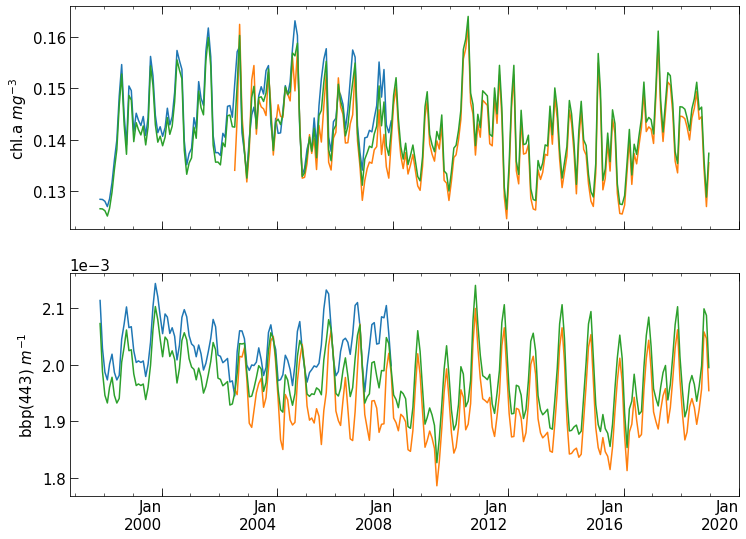

In [39]:
f, ax = pl.subplots(nrows=2, figsize=(12, 10), sharex=True)
df_all.plot(y=['s_chl_a_mean', 'a_chl_a_mean', 'chl_adj_mean'], ax=ax[0], legend=False)
df_all.plot(y=['s_bbp_443_giop_mean', 'a_bbp_443_giop_mean', 'bbp_adj_mean'], ax=ax[1], legend=False)
ax[0].set_ylabel('chl.a $mg^{-3}$')
ax[1].set_ylabel('bbp(443) $m^{-1}$')
set_time_axis(ax[0])
set_time_axis(ax[1])

In [40]:
df_both = df_all[['chl_adj_mean', 'bbp_adj_mean']].copy()

In [41]:
phyto_C_trace = df_both.bbp_adj_mean.values.reshape(1,-1) * slope + intercept

In [42]:
df_both['phyto_C_mean'] = phyto_C_trace.mean(axis=0)

In [43]:
phyto_C_50ci = pm.hpd(phyto_C_trace, alpha=0.5)
phyto_C_95ci = pm.hpd(phyto_C_trace, alpha=0.05)

In [44]:
df_both['phyto_C_50CI_hi'] = phyto_C_50ci[:, 1]
df_both['phyto_C_95CI_hi'] = phyto_C_95ci[:, 1]

In [45]:
df_both.insert(2, 'phyto_C_50CI_lo', phyto_C_50ci[:, 0])
df_both.insert(2, 'phyto_C_95CI_lo', phyto_C_95ci[:, 0])

In [46]:
df_both.head()

,chl_adj_mean,bbp_adj_mean,phyto_C_95CI_lo,phyto_C_50CI_lo,phyto_C_mean,phyto_C_50CI_hi,phyto_C_95CI_hi
datetime,,,,,,,
1997-11-15,0.126552,0.002073,22.757247,24.142836,24.841083,25.530049,26.981910
1997-12-15,0.126516,0.001988,21.980533,23.123099,23.845324,24.430774,25.972896
1998-01-15,0.126163,0.001946,21.502099,22.655481,23.347797,23.930489,25.382582
1998-02-15,0.125127,0.001933,21.347144,22.505127,23.187600,23.768797,25.193990
1998-03-15,0.126646,0.001961,21.685105,22.817465,23.517991,24.100255,25.604928


In [47]:
chl_ann_cycle = get_monthly_means(df_both[['chl_adj_mean']],
                                 year_start=2003, year_end=2011)
carb_ann_cycle = get_monthly_means(df_both[['phyto_C_mean']],
                                  year_start=2003, year_end=2011)

In [48]:
chl_ann_cycle

,chl_adj_mean
1,0.140039
2,0.145164
3,0.144552
4,0.143244
5,0.141956
6,0.144788
7,0.148271
8,0.148510
9,0.150857
10,0.140950


In [49]:
carb_ann_cycle

,phyto_C_mean
1,23.420878
2,23.191999
3,23.241575
4,23.566412
5,23.706025
6,23.462855
7,23.052000
8,23.352509
9,23.849429
10,24.537112


In [50]:
get_anomaly(df_both, chl_ann_cycle, name='chl_adj_mean', anomaly_name='chl_anomaly')
get_anomaly(df_both, carb_ann_cycle, name='phyto_C_mean', anomaly_name='phyto_C_anomaly')

In [51]:
df_both.head().T

datetime,1997-11-15 00:00:00,1997-12-15 00:00:00,1998-01-15 00:00:00,1998-02-15 00:00:00,1998-03-15 00:00:00
chl_adj_mean,0.126552,0.126516,0.126163,0.125127,0.126646
bbp_adj_mean,0.002073,0.001988,0.001946,0.001933,0.001961
phyto_C_95CI_lo,22.757247,21.980533,21.502099,21.347144,21.685105
phyto_C_50CI_lo,24.142836,23.123099,22.655481,22.505127,22.817465
phyto_C_mean,24.841083,23.845324,23.347797,23.187600,23.517991
phyto_C_50CI_hi,25.530049,24.430774,23.930489,23.768797,24.100255
phyto_C_95CI_hi,26.981910,25.972896,25.382582,25.193990,25.604928
chl_anomaly,-0.008520,-0.009597,-0.013876,-0.020037,-0.017906
phyto_C_anomaly,0.087324,-0.293074,-0.073082,-0.004399,0.276416


In [52]:
df_all.head()

,s_chl_a_mean,s_bbp_443_giop_mean,a_chl_a_mean,a_bbp_443_giop_mean,adj_chl_s,adj_chl_a,adj_bbp_s,adj_bbp_a,chl_adj_mean,bbp_adj_mean
datetime,,,,,,,,,,
1997-11-15,0.128396,0.002114,NaN,NaN,0.126552,NaN,0.002073,NaN,0.126552,0.002073
1997-12-15,0.128360,0.002029,NaN,NaN,0.126516,NaN,0.001988,NaN,0.126516,0.001988
1998-01-15,0.128007,0.001987,NaN,NaN,0.126163,NaN,0.001946,NaN,0.126163,0.001946
1998-02-15,0.126971,0.001973,NaN,NaN,0.125127,NaN,0.001933,NaN,0.125127,0.001933
1998-03-15,0.128490,0.002002,NaN,NaN,0.126646,NaN,0.001961,NaN,0.126646,0.001961


In [53]:
df_both.head()

,chl_adj_mean,bbp_adj_mean,phyto_C_95CI_lo,phyto_C_50CI_lo,phyto_C_mean,phyto_C_50CI_hi,phyto_C_95CI_hi,chl_anomaly,phyto_C_anomaly
datetime,,,,,,,,,
1997-11-15,0.126552,0.002073,22.757247,24.142836,24.841083,25.530049,26.981910,-0.008520,0.087324
1997-12-15,0.126516,0.001988,21.980533,23.123099,23.845324,24.430774,25.972896,-0.009597,-0.293074
1998-01-15,0.126163,0.001946,21.502099,22.655481,23.347797,23.930489,25.382582,-0.013876,-0.073082
1998-02-15,0.125127,0.001933,21.347144,22.505127,23.187600,23.768797,25.193990,-0.020037,-0.004399
1998-03-15,0.126646,0.001961,21.685105,22.817465,23.517991,24.100255,25.604928,-0.017906,0.276416


In [54]:
def get_sensor(row):
    if np.isfinite(row['adj_chl_s'] * row['adj_chl_a']):
        return 'both'
    else:
        if np.isfinite(row['adj_chl_s']):
            return 'swf'
        else:
            return 'aqua'
df_both['sensor'] =df_all.apply(get_sensor, axis=1)

In [55]:
df_both.head()

,chl_adj_mean,bbp_adj_mean,phyto_C_95CI_lo,phyto_C_50CI_lo,phyto_C_mean,phyto_C_50CI_hi,phyto_C_95CI_hi,chl_anomaly,phyto_C_anomaly,sensor
datetime,,,,,,,,,,
1997-11-15,0.126552,0.002073,22.757247,24.142836,24.841083,25.530049,26.981910,-0.008520,0.087324,swf
1997-12-15,0.126516,0.001988,21.980533,23.123099,23.845324,24.430774,25.972896,-0.009597,-0.293074,swf
1998-01-15,0.126163,0.001946,21.502099,22.655481,23.347797,23.930489,25.382582,-0.013876,-0.073082,swf
1998-02-15,0.125127,0.001933,21.347144,22.505127,23.187600,23.768797,25.193990,-0.020037,-0.004399,swf
1998-03-15,0.126646,0.001961,21.685105,22.817465,23.517991,24.100255,25.604928,-0.017906,0.276416,swf


In [56]:
df_both.sensor.value_counts()

aqua    132
both     66
swf      56
Name: sensor, dtype: int64

In [57]:
df_both.to_pickle('./pklJar/df_consolidated_%s.pkl' % datetime.now())
df_all.to_pickle('./pklJar/df_all_%s.pkl' % datetime.now())